In [82]:
from statsbombpy import sb
import pandas as pd

In [83]:
#find ids for bayer matches
matches = sb.matches(competition_id=9, season_id=281)
match_ids = matches['match_id'].values.tolist()

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [84]:
#All events sorted for bayer home games and possession 
events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2023/2024",
    gender="male"
)

season_matches = sb.matches(competition_id=9, season_id=281)
match_ids = season_matches['match_id'].values.tolist()
bayer_events = events[events['match_id'].isin(match_ids)]
event_df = events[events["team"]=="Bayer Leverkusen"]
df = event_df[event_df["possession_team"]=="Bayer Leverkusen"]

C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
C:\Users\thors\AppData\Roaming\Python\Python312\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [85]:
#filter threshold for Xg:
df_xg = df[~df['shot_statsbomb_xg'].between(0, 0.05)]

In [86]:
#Events sorted in a specific order so each passing sequence is correctly sorted
sequences_sorted = df_xg.sort_values(['match_id', 'period','timestamp'], ascending=[True, True, True])

In [87]:
#make new ids because right now there is ids from 1 to x for each match but it repeats from 1 and up in every match so each possession id points to different matches 
# - i just put the possession id after match_id in the newly created id
sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)
sequences_sorted['possession_id'] = sequences_sorted['possession_id'].astype(int)

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\955078220.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_sorted['possession_id'] = sequences_sorted['match_id'].astype(str) + sequences_sorted['possession'].astype(str)


In [88]:
#get the ids of sequences which contain a shot (contain an xg value)
shot_sequences = sequences_sorted[sequences_sorted["shot_statsbomb_xg"].notna()]
shot_sequences_ids = shot_sequences["possession_id"].unique()

In [89]:
#filter for possession sequences which end with a shot
sequences_filtered = sequences_sorted[sequences_sorted['possession_id'].isin(shot_sequences_ids)]

In [90]:
#fill all rows with an xg for the corresponding sequence - right now there are many missing values in "shot_statsbomb_xg"
sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\2851514471.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\2851514471.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['xg'] = sequences_filtered.groupby('possession_id')['shot_statsbomb_xg'].transform(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\2851514471.py:2: SettingWithCopyWarning: 
A value is trying to be s

In [91]:
#make end location for passes and carries (start location has no missing values)
#combine the two types (pass and carry) into one location column (now we dont know if an edge is a pass or carry btw)
sequences_filtered['end_location'] = sequences_filtered['location'].shift(-1)

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1044016736.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['end_location'] = sequences_filtered['location'].shift(-1)
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1044016736.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered['end_location'] = sequences_filtered['location'].shift(-1)


In [92]:
#now we dont need the shot event rows any more so remove them
sequences_filtered = sequences_filtered[sequences_filtered["type"]!="Shot"]

In [93]:
#assign x and y coordinates from location lists
sequences_filtered["start_x"] = sequences_filtered["location"].str[0]
sequences_filtered["start_y"] = sequences_filtered["location"].str[1]
sequences_filtered["end_x"] = sequences_filtered["end_location"].str[0]
sequences_filtered["end_y"] = sequences_filtered["end_location"].str[1]

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1692549575.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_x"] = sequences_filtered["location"].str[0]
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1692549575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_y"] = sequences_filtered["location"].str[1]
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1692549575.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [94]:
#reduce the number of possible x and y coordinates, essentially making the fields/nodes of the pitch larger
sequences_filtered['start_node_x'] = sequences_filtered["start_x"]
sequences_filtered['start_node_y'] = sequences_filtered["start_y"]
sequences_filtered['end_node_x'] = sequences_filtered["end_x"]
sequences_filtered['end_node_y'] = sequences_filtered["end_y"]

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\222620252.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['start_node_x'] = sequences_filtered["start_x"]
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\222620252.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered['start_node_y'] = sequences_filtered["start_y"]
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\222620252.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

In [95]:
#invert y values in second period
sequences_filtered_p1 = sequences_filtered[sequences_filtered["period"]==1]
sequences_filtered_p2 = sequences_filtered[sequences_filtered["period"]==2]
sequences_filtered_p2["start_node_y"] = 80 - sequences_filtered_p2["start_node_y"] 
sequences_filtered_p2["end_node_y"] = 80 - sequences_filtered_p2["end_node_y"] 

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1091065939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered_p2["start_node_y"] = 80 - sequences_filtered_p2["start_node_y"]
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\1091065939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequences_filtered_p2["end_node_y"] = 80 - sequences_filtered_p2["end_node_y"]


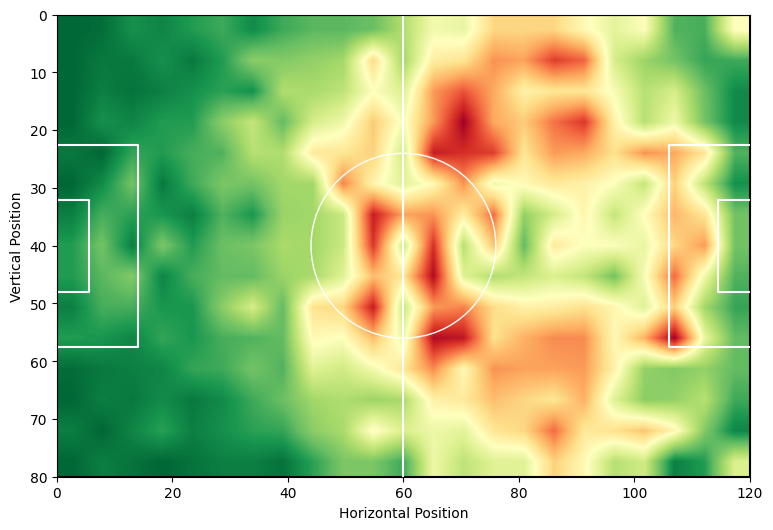

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataset has been properly loaded and contains 'start_x' and 'start_y' columns
# For demonstration, we will create a mock dataset to simulate your data
# Replace this part with the actual dataset loading code if needed

# Mock data (replace this with your actual data)


# Create a heatmap on a soccer pitch with continuous density representation
pitch_length = 120
pitch_width = 80

# Plot the soccer pitch
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot([0, 0, pitch_length, pitch_length, 0], [0, pitch_width, pitch_width, 0, 0], color="black")
plt.plot([0, 14, 14, 0], [22.5, 22.5, 57.5, 57.5], color="white")  # Penalty box on the left
plt.plot([0, 5.5, 5.5, 0], [32, 32, 48, 48], color="white")
plt.plot([pitch_length, pitch_length - 14, pitch_length - 14, pitch_length], [22.5, 22.5, 57.5, 57.5], color="white")  # Penalty box on the right
plt.plot([pitch_length, pitch_length - 5.5, pitch_length - 5.5, pitch_length], [32, 32, 48, 48], color="white") 
plt.axvline(pitch_length / 2, color="white")  # Halfway line
plt.gca().add_patch(plt.Circle((pitch_length / 2, pitch_width / 2), 16, color='white', fill=False))  # Center circle

# Use a 2D histogram with smaller bins for a smoother heatmap
heatmap, xedges, yedges = np.histogram2d(sequences_filtered['start_node_x'], sequences_filtered['start_node_y'], bins=[23, 15], range=[[0, pitch_length], [0, pitch_width]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the continuous heatmap using interpolation
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='RdYlGn_r', alpha=1, interpolation='bilinear')

# Customize the plot
ax.set_xlabel('Horizontal Position')
ax.set_ylabel('Vertical Position')
plt.gca().invert_yaxis()

plt.savefig("heatmap passes.pdf",bbox_inches="tight")


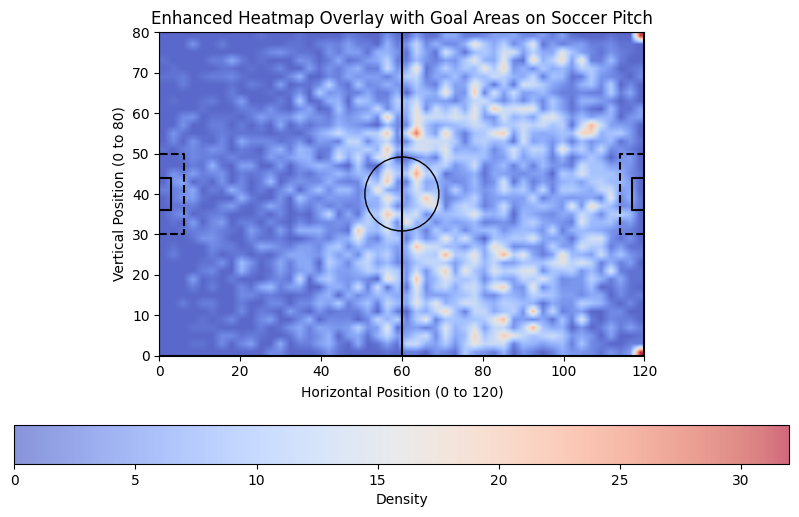

In [121]:
pitch_length = 120
pitch_width = 80

# Plot the soccer pitch with goal areas
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot([0, 0, pitch_length, pitch_length, 0], [0, pitch_width, pitch_width, 0, 0], color="black")
plt.axvline(pitch_length / 2, color="black")  # Halfway line
plt.gca().add_patch(plt.Circle((pitch_length / 2, pitch_width / 2), 9.15, color='black', fill=False))  # Center circle

# Add the goal areas
# Left goal area
plt.plot([0, 6, 6, 0], [30, 30, 50, 50], color="black", linestyle="--")  # Penalty box on the left
plt.plot([0, 3, 3, 0], [36, 36, 44, 44], color="black")  # Goal area on the left

# Right goal area
plt.plot([pitch_length, pitch_length - 6, pitch_length - 6, pitch_length], [30, 30, 50, 50], color="black", linestyle="--")  # Penalty box on the right
plt.plot([pitch_length, pitch_length - 3, pitch_length - 3, pitch_length], [36, 36, 44, 44], color="black")  # Goal area on the right

# Create a 2D histogram for the heatmap
bin_size_x = 50  # Number of bins along the x-axis
bin_size_y = 40  # Number of bins along the y-axis
heatmap, xedges, yedges = np.histogram2d(sequences_filtered['start_node_x'], sequences_filtered['start_node_y'], bins=[bin_size_x, bin_size_y], range=[[0, pitch_length], [0, pitch_width]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot the heatmap with a color map similar to the reference image
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='coolwarm', alpha=0.6, interpolation='bilinear')

# Customize the plot
ax.set_title('Enhanced Heatmap Overlay with Goal Areas on Soccer Pitch')
ax.set_xlabel('Horizontal Position (0 to 120)')
ax.set_ylabel('Vertical Position (0 to 80)')
plt.gca().invert_yaxis()

plt.colorbar(ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='coolwarm', alpha=0.6, interpolation='bilinear'), orientation='horizontal', label='Density')

plt.show()

In [96]:
#concatenate the two period dataframes
sequences_filtered = pd.concat([sequences_filtered_p1,sequences_filtered_p2], axis=0, ignore_index=True)

In [97]:
#combine the x and y coordinates
sequences_filtered["start_node"] = sequences_filtered["start_node_x"] + sequences_filtered["start_node_y"] / 10
sequences_filtered["end_node"] = sequences_filtered["end_node_x"] + sequences_filtered["end_node_y"] / 10

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\2377205678.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["start_node"] = sequences_filtered["start_node_x"] + sequences_filtered["start_node_y"] / 10
C:\Users\thors\AppData\Local\Temp\ipykernel_6252\2377205678.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequences_filtered["end_node"] = sequences_filtered["end_node_x"] + sequences_filtered["end_node_y"] / 10


In [78]:
#sort to desired columns
sequences_filtered = sequences_filtered[["start_node","end_node","xg","possession_id"]]

In [79]:
#remove edges between the same node if wanted
final_sequences = sequences_filtered[sequences_filtered['start_node'] != sequences_filtered['end_node']]

In [80]:
#remove rows with missing values - there are only a few
final_sequences.dropna(inplace=True)

C:\Users\thors\AppData\Local\Temp\ipykernel_6252\309154560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sequences.dropna(inplace=True)


In [36]:
#remove sequences with few passes if wanted
index_counts = final_sequences['possession_id'].value_counts()
final_sequences = final_sequences[final_sequences['possession_id'].isin(index_counts[index_counts > 5].index)]

In [37]:
#get all the unique possession ids for iteration
possession_index = final_sequences["possession_id"].unique()

In [38]:
import networkx as nx

#iterate over possession ids and each row and append edges to a list for each graph and append that graph to a graphs dictionary (directed graph created with "nx.DiGraph(edges)")
#xg added as an attribute for each graph
graphs_dict = {}
for j in possession_index:
    edges = []
    for i in final_sequences.index:
        if j == final_sequences["possession_id"][i]:
            edges.append((final_sequences["start_node"][i], final_sequences["end_node"][i]))
            if j not in graphs_dict:
                graphs_dict[j] = {"xg": final_sequences["xg"][i], "graph": None}
            else:
                graphs_dict[j]["xg"] = final_sequences["xg"][i]
                
    graph = nx.DiGraph(edges)
    graphs_dict[j]["graph"] = graph

graph_list = [value["graph"] for value in graphs_dict.values()]

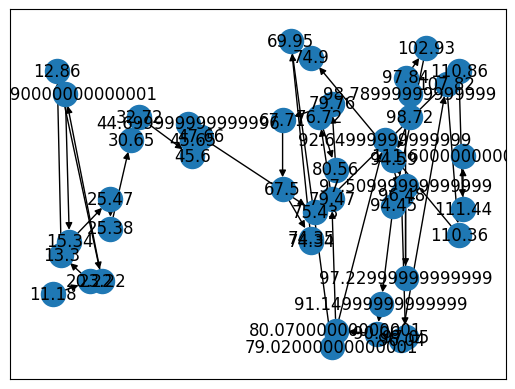

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

game_pos = 3895348127
# Extract positions from numeric node labels
positions = {}
for node in graphs_dict[game_pos]["graph"].nodes():
    # Convert the node to a string first, then split by the decimal
    x = int(node)  # Integer part represents the x position
    y = node - x   # Decimal part represents the y position
    positions[node] = (x, y)

# Draw the graph using the positions
nx.draw_networkx(graphs_dict[game_pos]["graph"], pos=positions)

# Show the plot
plt.show()


In [40]:
k_core_results = []

# Loop through each graph in the list and perform k-core decomposition
for idx, graph in enumerate(graph_list):
    k_core_result = nx.core_number(graph)
    
    # Convert the result to a DataFrame for easier visualization
    k_core_df = pd.DataFrame(list(k_core_result.items()), columns=['Zone', 'K-core Value'])
    k_core_df['Graph Index'] = idx  # Adding a column to identify which graph the results belong to
    
    # Append the result to the list of results
    k_core_results.append(k_core_df)

# Combine all results into a single DataFrame
final_k_core_df = pd.concat(k_core_results, ignore_index=True)

# Display the combined results using pandas display
print(final_k_core_df)


        Zone  K-core Value  Graph Index
0      90.53             1            0
1      91.08             1            0
2     113.05             1            0
3     120.77             1            0
4     120.58             1            0
...      ...           ...          ...
6625  104.53             1          245
6626  104.52             1          245
6627  101.39             1          245
6628   99.56             1          245
6629  100.29             1          245

[6630 rows x 3 columns]


In [41]:
final_k_core_df["Zone"].value_counts()

Zone
120.00    14
128.00     9
127.99     9
115.00     6
60.86      5
          ..
104.53     1
104.52     1
101.39     1
99.56      1
59.35      1
Name: count, Length: 5213, dtype: int64